In [1]:
import pandas as pd
import numpy as np
#from numpy.random import seed
#seed(1)

cols= ['Q{}'.format(idx) for idx in range(1,11)]
data= pd.read_csv('ouirt.dat', sep= ' ', names= cols)
num_users= data.shape[0]

data.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
NaN,0,1,1,1,1,1,1,1,1,0
NaN,0,1,0,0,1,0,1,0,0,0


In [2]:
data= pd.DataFrame(data.values, columns=cols)
data.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* Truncate number of questions in dataframe

In [3]:
rel_items = cols[:]#all Questions 1-10
df = data[rel_items]

In [4]:
df_cols = ['user','questions', 'response']#final dataframe cols

from collections import defaultdict
di = defaultdict(dict)
for idx in rel_items:
    di[idx].update(zip(range(df.shape[0]), df[idx].values))#makes format {'Q1':{user:responses,1:0,2:0,. . .,}}

* Following dataframe contains-- user id, questions id, corresponding response value

In [5]:
df_list= list()
for ques, user_resp in list(zip(di.keys(), di.values())):
    df_list.append({'user':list(user_resp.keys()), 'questions':[ques]*df.shape[0], 'response':list(user_resp.values())})


df_new= pd.DataFrame()
for i in range(len(df_list)):
    df = pd.DataFrame(df_list[i])
    df_new= pd.concat([df_new, df], ignore_index=True)

df_new = df_new.loc[np.random.randint(0,df_new.shape[0]-1, size=df_new.shape[0])]#shuffling data
df_new.head(4)

,user,questions,response
4429,429,Q9,0
2948,448,Q6,0
4172,172,Q9,1
2858,358,Q6,0


## Defining Keras equivalent model

In [6]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

In [7]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_new[df_cols[:-1]], df_new[df_cols[-1]], test_size=0.05)

In [8]:
x_train_user = to_categorical(xtrain['user'], num_classes=500)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of x_train_user:', x_train_user.shape,'\nshape of x_train_questions:', x_train_questions.shape,
      '\nshape of y_train:',y_train.shape)

shape of x_train_user: (4750, 500) 
shape of x_train_questions: (4750, 10) 
shape of y_train: (4750,)


## 3 PL IRT model
* t_i= Degree of latent trait of i-th student
* b_j= difficulty_level of j-th question
* a_j= discrimination parameter of j-th question
* c_j= pseudo guessing parameter of j-th question
* P(i,j) = Prob of i-th student, correctly scoring on j-th item.

`P{i=1,j} = c_j+ (1- c_j)*Sigmoid[a_j*(t_i - b_j)]`

In [9]:
from keras import backend as K
from keras.layers import Lambda
from keras import regularizers
from keras import initializers
from keras.layers import Activation

In [10]:
user_input_layer = Input(shape=(x_train_user.shape[1],), name= 'user_id')#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],), name='questions/items')#bottom half of input

#1. kernel init set to RandomNorm(0,1), kernel regularizer set to l2
latent_trait = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=1, stddev=0.5, seed=None),
        kernel_regularizer=regularizers.l2(0.01), name='latent_trait')(user_input_layer)

#2. kernel init set to RandomNorm(0,1),
difficulty_level = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=0, stddev=1.0, seed=None),
        name='difficulty_level')(quest_input_layer)

#3. kernel init set to RandomNorm(1,1),
discrimination_param = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=1, stddev=1.0, seed=None),
        name='disc_param')(quest_input_layer)

#4. added Sigmoid activation
guess_param = Dense(1, use_bias=False, activation='sigmoid', name='guessing_param')(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract(name='latent_diff_sub')([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply(name='disc_param_inter.')([latent_difficulty_subtract, 
                                                    discrimination_param])

#5. Sigmoid positioning corrected as per 3PL expression
sigmoid_layer= Activation('sigmoid', name='Sigmoid_func')(disc_param_interaction)


guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([1])) - x, name='guess_param_inter.')(guess_param)


guess_param_interaction= keras.layers.Multiply(name='disc/guess_param_inter.')([sigmoid_layer,
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add(name='guess_param_inter/add')([guess_param, guess_param_interaction])


#6. changed activation to just linear
prediction_output = Dense(1, trainable=False, use_bias=False,kernel_initializer=keras.initializers.Ones(), name='prediction_layer')(guess_param_interaction)


model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)
model3.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 10)           0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            500         user_id[0][0]                    
__________________________________________________________________________________________________
difficulty_level (Dense)        (None, 1)            10          questions/items[0][0]            
____________________________________________________________________________________________

In [12]:
history= model3.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 3800 samples, validate on 950 samples
Epoch 1/8
3800/3800 [==============================] - 0s 48us/step - loss: 7.8335 - mae: 0.6253 - accuracy: 0.2982 - val_loss: 7.6143 - val_mae: 0.6221 - val_accuracy: 0.2958
Epoch 2/8
3800/3800 [==============================] - 0s 24us/step - loss: 7.4284 - mae: 0.6178 - accuracy: 0.2987 - val_loss: 7.2291 - val_mae: 0.6145 - val_accuracy: 0.2947
Epoch 3/8
3800/3800 [==============================] - 0s 23us/step - loss: 7.0564 - mae: 0.6105 - accuracy: 0.2989 - val_loss: 6.8738 - val_mae: 0.6072 - val_accuracy: 0.2958
Epoch 4/8
3800/3800 [==============================] - 0s 24us/step - loss: 6.7126 - mae: 0.6032 - accuracy: 0.3000 - val_loss: 6.5446 - val_mae: 0.6001 - val_accuracy: 0.2968
Epoch 5/8
3800/3800 [==============================] - 0s 23us/step - loss: 6.3934 - mae: 0.5963 - accuracy: 0.3000 - val_loss: 6.2380 - val_mae: 0.5933 - val_accuracy: 0.2968
Epoch 6/8
3800/3800 [====

* Train Vs. Validation loss curves

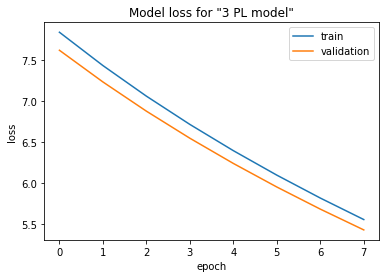

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "3 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### Obtaining underlying trained 3pl parameters from keras model

In [15]:
for idx in [2,3,5,6]:
    print('layer no: {} is named: {}'.format(idx, model3.layers[idx].name))

layer no: 2 is named: latent_trait
layer no: 3 is named: difficulty_level
layer no: 5 is named: disc_param
layer no: 6 is named: guessing_param


In [16]:
latent_trait_parameters = model3.layers[2].get_weights()[0]#latent trait for 500 users
difficulty_level_parameters= model3.layers[3].get_weights()[0]#difficulty params for 3 Quests/item.
discrimination_parameters= model3.layers[5].get_weights()[0]#dicrimination params for 3 Quests/item.
pseudo_guess_parameters = model3.layers[6].get_weights()[0]#pseudo_guess_params for 3 Quests/item.

In [17]:
difficulty_level_parameters

array([[ 1.3686088 ],
       [ 0.8131264 ],
       [ 0.19115607],
       [ 1.2853312 ],
       [-1.3606592 ],
       [ 1.4281342 ],
       [ 0.7347629 ],
       [ 1.0079952 ],
       [ 0.77454853],
       [ 0.03781628]], dtype=float32)

In [18]:
discrimination_parameters

array([[ 0.83213633],
       [ 1.0419834 ],
       [ 0.09421235],
       [ 1.6124957 ],
       [-0.16175753],
       [ 0.8345809 ],
       [ 1.9702649 ],
       [ 1.9361265 ],
       [ 0.08724365],
       [ 0.7033399 ]], dtype=float32)

In [19]:
pseudo_guess_parameters#Old vals with kernel init glorot uniform

array([[-0.44032007],
       [-0.3536119 ],
       [ 0.05402391],
       [ 0.08344492],
       [-0.867724  ],
       [-0.74547565],
       [-0.5801957 ],
       [-0.46452302],
       [-0.554316  ],
       [-0.15812075]], dtype=float32)

### Histogram of latent traits/abilities from keras_3PL

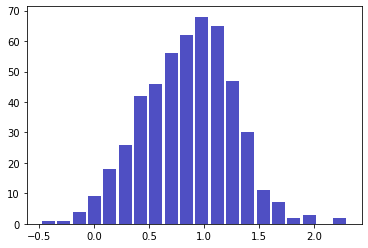

In [20]:
n, bins, patches = plt.hist(x=latent_trait_parameters, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

### Importing R's 3PL model paramters for comparison

In [21]:
coeff = pd.read_csv('coeffs.csv')
coeff.head(3)

,Unnamed: 0,Gussng,Dffclt,Dscrmn
0,V1,0.000025,1.636048,1.414799
1,V2,0.106400,1.214459,2.006961
2,V3,0.000048,0.817690,1.208465


In [22]:
r_params_cols= list(coeff.columns)
r_params_cols#columns from R's dataframe

['Unnamed: 0', 'Gussng', 'Dffclt', 'Dscrmn']

* Normalising Difficulty, Descrimination values from R's dataframe

In [23]:
normalized_diff_r=coeff[r_params_cols[2]]#/coeff[r_params_cols[2]].sum()
normalized_diff_r#new difficulty vals from R

0    1.636048
1    1.214459
2    0.817690
3    0.890029
4    0.257974
5    0.746576
6    0.477205
7    0.651561
8    0.656884
9    1.919147
Name: Dffclt, dtype: float64

## Scatterplots

### 1. Difficulty vals from keras_3pl vs. R_3pl
* Keras values are plotted across X
* R_tpm values are plotted across Y

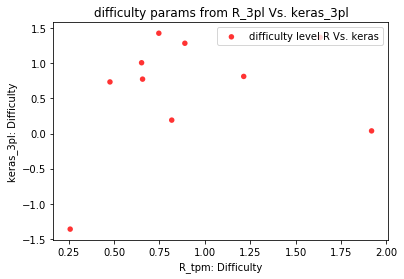

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (difficulty_level_parameters.reshape(-1), normalized_diff_r.values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="difficulty level R Vs. keras")
plt.title('difficulty params from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: Difficulty')
plt.xlabel('R_tpm: Difficulty')
plt.legend(loc=1)

plt.show()

### 2. Discrimination vals from keras_3pl vs. R_3pl
* Keras values are plotted across X
* R_tpm values are plotted across Y

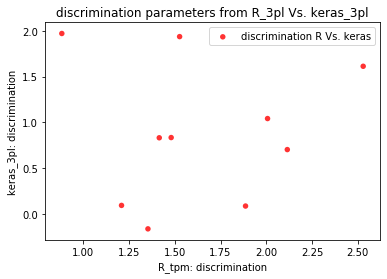

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (discrimination_parameters, coeff[r_params_cols[-1]].values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="discrimination R Vs. keras")
plt.title('discrimination parameters from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: discrimination')
plt.xlabel('R_tpm: discrimination')

plt.legend(loc=1)
plt.show()

### 3. Guessing param values from keras_3pl vs. R_3pl
* Keras values are plotted across X
* R_tpm values are plotted across Y

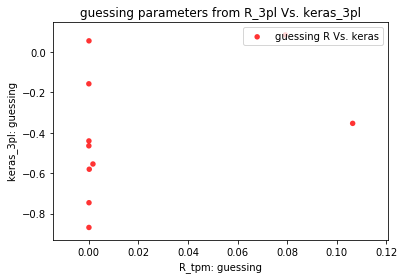

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (pseudo_guess_parameters, coeff[r_params_cols[1]].values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="guessing R Vs. keras")
plt.title('guessing parameters from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: guessing')
plt.xlabel('R_tpm: guessing')

plt.legend(loc=1)
plt.show()

## Item Characteristic curves from keras_3pl vs. R_3pl
* Comparing `P(i,j)` value curves per item for all users using params from keras vs. params from R_tpm

In [27]:
coeff.head(3)

,Unnamed: 0,Gussng,Dffclt,Dscrmn
0,V1,0.000025,1.636048,1.414799
1,V2,0.106400,1.214459,2.006961
2,V3,0.000048,0.817690,1.208465


In [28]:
r_params_cols

['Unnamed: 0', 'Gussng', 'Dffclt', 'Dscrmn']

* **Item characterstic plotting function for 3PL**

In [29]:
def logit_func(lat_values):#c:guess, a:descrimination, b:difficulty
    prob = list()
    prob.append(c+ (1-c)*(np.exp(a*(lat_values-b))/(1+np.exp(a*(lat_values-b)))))#Vectorised implementation
    #for val in lat_values:
    #    prob.append(c+ (1-c)*(np.exp(a*(val-b))/(1+np.exp(a*(val-b)))))
    return prob

In [30]:
x = np.linspace(-4,4, num=num_users)#value count for x axis

### Individual plots for each item(1-10) across keras method vs. R tpm

#####  1. Calculating plots for R's item 1 & keras's item 1

In [31]:
coeff[r_params_cols[0]].iloc[0]

'V1'

In [32]:
#values of item 1 from R's dataframe
c= coeff[r_params_cols[1]].iloc[0]#c:guess
a= coeff[r_params_cols[-1]].iloc[0]#a:descrimination
b= coeff[r_params_cols[2]].iloc[0]#b:difficulty
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[0]#values for item 1 from keras 3pl params
a= discrimination_parameters[0]
b= difficulty_level_parameters[0]
vals_keras= logit_func(x)#logits for R's dataframe

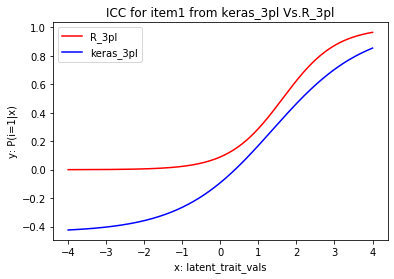

In [33]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item1 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 2. Calculating plots for R's item 2 & keras's item 2

In [34]:
coeff[r_params_cols[0]].iloc[1]

'V2'

In [35]:
c= coeff[r_params_cols[1]].iloc[1]#values of item 2 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[1]
b= coeff[r_params_cols[2]].iloc[1]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[1]#values for item 2 from keras 3pl params
a= discrimination_parameters[1]
b= difficulty_level_parameters[1]
vals_keras= logit_func(x)#logits for R's dataframe

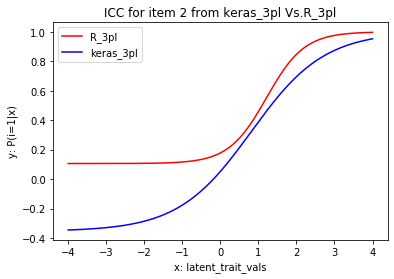

In [36]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 2 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 3. Calculating plots for R's item 3 & keras's item 3

In [37]:
coeff[r_params_cols[0]].iloc[2]

'V3'

In [38]:
c= coeff[r_params_cols[1]].iloc[2]#values of item 3 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[2]
b= coeff[r_params_cols[2]].iloc[2]
vals_r= logit_func(x)#logits for R's dataframe
####
c= pseudo_guess_parameters[2]#values for item 3 from keras 3pl params
a= discrimination_parameters[2]
b= difficulty_level_parameters[2]
vals_keras= logit_func(x)#logits for R's dataframe

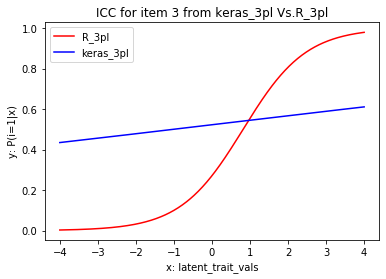

In [39]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 3 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 4. Calculating plots for R's item 3 & keras's item 4

In [40]:
coeff[r_params_cols[0]].iloc[3]

'V4'

In [41]:
c= coeff[r_params_cols[1]].iloc[3]#values of item 4 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[3]
b= coeff[r_params_cols[2]].iloc[3]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[3]#values for item 4 from keras 3pl params
a= discrimination_parameters[3]
b= difficulty_level_parameters[3]
vals_keras= logit_func(x)#logits for R's dataframe

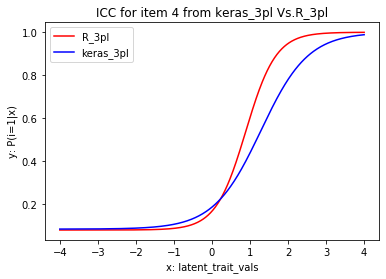

In [42]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 4 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 5. Calculating plots for R's item 3 & keras's item 5

In [43]:
coeff[r_params_cols[0]].iloc[4]

'V5'

In [44]:
c= coeff[r_params_cols[1]].iloc[4]#values of item 5 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[4]
b= coeff[r_params_cols[2]].iloc[4]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[4]#values for item 5 from keras 3pl params
a= discrimination_parameters[4]
b= difficulty_level_parameters[4]
vals_keras= logit_func(x)#logits for R's dataframe

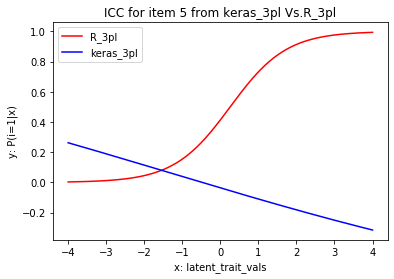

In [45]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 5 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 6. Calculating plots for R's item 3 & keras's item 6

In [46]:
coeff[r_params_cols[0]].iloc[5]

'V6'

In [47]:
c= coeff[r_params_cols[1]].iloc[5]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[5]
b= coeff[r_params_cols[2]].iloc[5]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[5]#values for item 6 from keras 3pl params
a= discrimination_parameters[5]
b= difficulty_level_parameters[5]
vals_keras= logit_func(x)#logits for R's dataframe

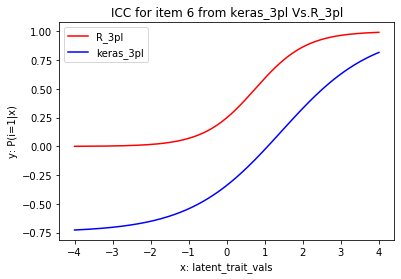

In [48]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 6 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 7. Calculating plots for R's item 3 & keras's item 7

In [49]:
coeff[r_params_cols[0]].iloc[6]

'V7'

In [50]:
c= coeff[r_params_cols[1]].iloc[6]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[6]
b= coeff[r_params_cols[2]].iloc[6]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[6]#values for item 6 from keras 3pl params
a= discrimination_parameters[6]
b= difficulty_level_parameters[6]
vals_keras= logit_func(x)#logits for R's dataframe

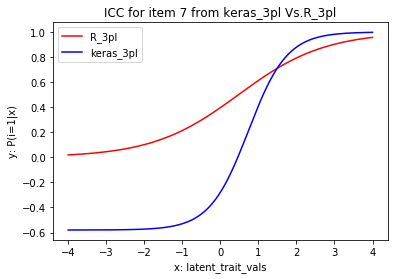

In [51]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 7 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 8. Calculating plots for R's item 3 & keras's item 8

In [52]:
coeff[r_params_cols[0]].iloc[7]

'V8'

In [53]:
c= coeff[r_params_cols[1]].iloc[7]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[7]
b= coeff[r_params_cols[2]].iloc[7]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[7]#values for item 6 from keras 3pl params
a= discrimination_parameters[7]
b= difficulty_level_parameters[7]
vals_keras= logit_func(x)#logits for R's dataframe

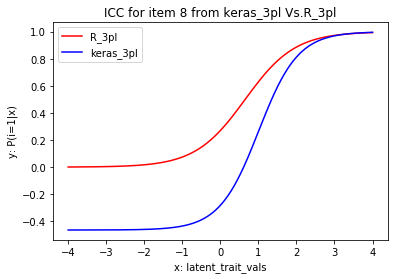

In [54]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 8 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 9. calculating plots for R's item 3 & keras's item 9

In [55]:
coeff[r_params_cols[0]].iloc[8]

'V9'

In [56]:
c= coeff[r_params_cols[1]].iloc[8]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[8]
b= coeff[r_params_cols[2]].iloc[8]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[8]#values for item 6 from keras 3pl params
a= discrimination_parameters[8]
b= difficulty_level_parameters[8]
vals_keras= logit_func(x)#logits for R's dataframe

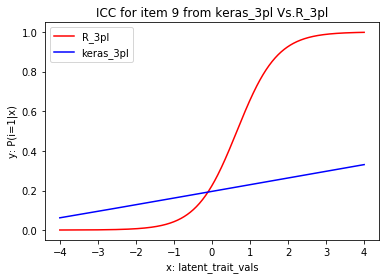

In [57]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 9 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

#### 10. Calculating plots for R's item 3 & keras's item 10

In [58]:
coeff[r_params_cols[0]].iloc[9]

'V10'

In [59]:
c= coeff[r_params_cols[1]].iloc[9]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[9]
b= coeff[r_params_cols[2]].iloc[9]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[9]#values for item 6 from keras 3pl params
a= discrimination_parameters[9]
b= difficulty_level_parameters[9]
vals_keras= logit_func(x)#logits for R's dataframe

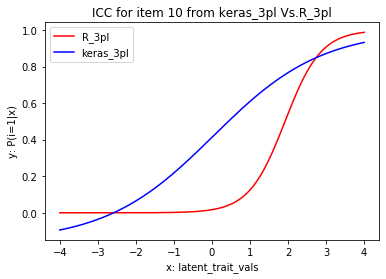

In [60]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 10 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

## Item characteristic curves for all items from R tpm

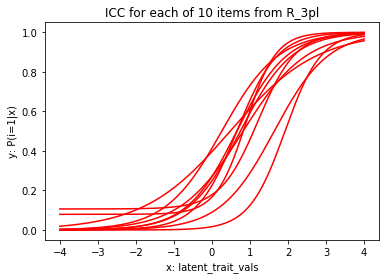

In [61]:
for i in range(coeff.shape[0]):
    c= coeff[r_params_cols[1]].iloc[i]#values of item 6 from R's dataframe
    a= coeff[r_params_cols[-1]].iloc[i]
    b= coeff[r_params_cols[2]].iloc[i]
    vals_r= logit_func(x)
    plt.plot(x,vals_r[0], 'r')

plt.title('ICC for each of 10 items from R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()

## Item characteristic curves for all items from keras 3PL

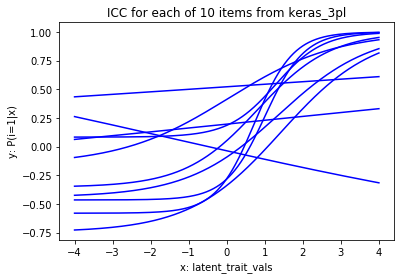

In [62]:
for i in range(len(rel_items)):#10 items
    c= pseudo_guess_parameters[i]#values for item 6 from keras 3pl params
    a= discrimination_parameters[i]
    b= difficulty_level_parameters[i]
    vals_keras= logit_func(x)
    plt.plot(x,vals_keras[0], 'b')

plt.title('ICC for each of 10 items from keras_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()#for mean=1.0, stdDev=0.5

-------------